<a href="https://colab.research.google.com/github/boroju/aidl-upc-winter2024-satellite-imagery/blob/main/GeoTiff_DataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DataLoader

Reading TIF file, convert to `xarray.DataArray`, split into chips and embed into a PyTorch DataLoader using zen3geo

In [ ]:
!pip install 'stackstac[viz]'
!pip install zen3geo
# !pip install pyogrio[geopandas]
!pip install xbatcher
!pip install odc-stac
!pip install rioxarray


https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python-xarray/

![](https://www.earthdatascience.org/images/earth-analytics/raster-data/raster-concept.png)


In [1]:
import rioxarray # for the extension to load
import xarray

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/My Drive/COPERNICUS_S2_SR_ee'
import os
from os import listdir
from os.path import isfile, join
file_paths = [os.path.join(path, f) for f in listdir(path) if isfile(join(path, f))]
file_paths[:2]

['/content/drive/My Drive/COPERNICUS_S2_SR_ee/20210805T185919_20210805T190825_T10TDK.tif',
 '/content/drive/My Drive/COPERNICUS_S2_SR_ee/20210805T185919_20210805T190825_T10TEK.tif']

In [4]:
file_paths[0]

'/content/drive/My Drive/COPERNICUS_S2_SR_ee/20210805T185919_20210805T190825_T10TDK.tif'

In [5]:
xds = xarray.open_dataarray(file_paths[0], chunks={'x':512, 'y':512})
xds

<xarray.DataArray 'band_data' (band: 6, y: 1101, x: 1099)>
dask.array<open_dataset-band_data, shape=(6, 1101, 1099), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 4 5 6
  * x            (x) float64 4e+05 4e+05 4.002e+05 ... 5.096e+05 5.098e+05
  * y            (y) float64 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
    spatial_ref  int64 ...
Attributes: (12/89)
    AOT_RETRIEVAL_ACCURACY:                0
    AREA_OR_POINT:                         Area
    CLOUDY_PIXEL_PERCENTAGE:               17.299285
    CLOUD_COVERAGE_ASSESSMENT:             17.299285
    CLOUD_SHADOW_PERCENTAGE:               0.000342
    DARK_FEATURES_PERCENTAGE:              0.49671
    ...                                    ...
    description:                           Blue
    gsd:                                   10
    name:                                  B2
    scale:                                 0.0001
    wavelength:                            496.6nm (S2A) / 492.1nm (S2B)
    long_name:                             ('B2', 'B3', 'B4', 'TCI_R', 'TCI_G...

In [6]:
xds.shape


(6, 1101, 1099)

In [7]:
xds.rio.width

1099

In [8]:
xds.rio.height

1101

In [9]:
xds.rio.crs

CRS.from_epsg(32610)

In [10]:
xds.rio.resolution()

(100.0, -100.0)

In [11]:
from rasterio.enums import Resampling

upscale_factor = 2
new_width = xds.rio.width * upscale_factor
new_height = xds.rio.height * upscale_factor

xds_upsampled = xds.rio.reproject(
    xds.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.bilinear,
)


In [12]:
xds_upsampled.shape

(6, 2202, 2198)

In [13]:
rds = rioxarray.open_rasterio(file_paths[0], masked=True)

In [14]:
rds

<xarray.DataArray (band: 6, y: 1101, x: 1099)>
[7259994 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6
  * x            (x) float64 4e+05 4e+05 4.002e+05 ... 5.096e+05 5.098e+05
  * y            (y) float64 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
    spatial_ref  int64 0
Attributes: (12/91)
    AOT_RETRIEVAL_ACCURACY:                0
    AREA_OR_POINT:                         Area
    CLOUDY_PIXEL_PERCENTAGE:               17.299285
    CLOUD_COVERAGE_ASSESSMENT:             17.299285
    CLOUD_SHADOW_PERCENTAGE:               0.000342
    DARK_FEATURES_PERCENTAGE:              0.49671
    ...                                    ...
    name:                                  B2
    scale:                                 0.0001
    wavelength:                            496.6nm (S2A) / 492.1nm (S2B)
    scale_factor:                          1.0
    add_offset:                            0.0
    long_name:                             ('B2', 'B3', 'B4', 'TCI_R', 'TCI_G...

https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python-xarray/





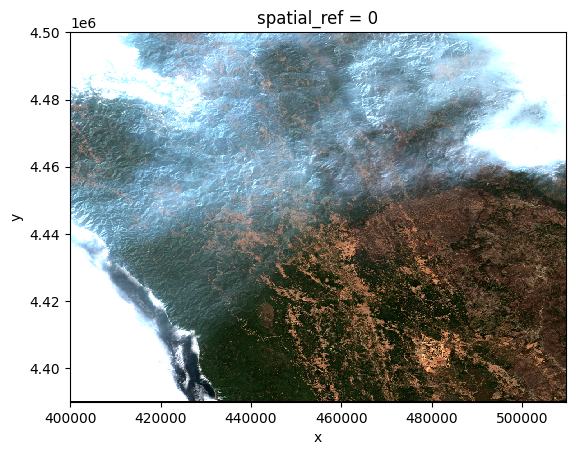

In [15]:
# Seleccionamos las 3 primeras bandas
# rgb_bands = ["B04", "B03", "B02"]
# .select(['B2', 'B3', 'B4', 'TCI_R', 'TCI_G', 'TCI_B'])

# rds = rds.sel(band=[3,2,1])
rds = rds.sel(band=[4,5,6])

rds.astype("int").plot.imshow(rgb="band")


In [16]:
# View the Coordinate Reference System (CRS) & spatial extent
print("The CRS for this data is:", rds.rio.crs)
print("The spatial extent is:", rds.rio.bounds())
# View no data value
print("The no data value is:", rds.rio.nodata)

The CRS for this data is: EPSG:32610
The spatial extent is: (399900.0, 4390000.0, 509800.0, 4500100.0)
The no data value is: nan


In [17]:
# rds.plot()
# plt.show()

In [18]:
import numpy as np
print("the minimum raster value is: ", np.nanmin(rds.values))
print("the maximum raster value is: ", np.nanmax(rds.values))

the minimum raster value is:  1.0
the maximum raster value is:  255.0


In [19]:
rds.shape

(3, 1101, 1099)

In [20]:
import pystac
import stackstac
from zen3geo.datapipes import StackSTACStacker

In [21]:
url: str = file_paths[0]
print(url)

/content/drive/My Drive/COPERNICUS_S2_SR_ee/20210805T185919_20210805T190825_T10TDK.tif


In [22]:
from torchdata.datapipes.iter import IterableWrapper
dp = IterableWrapper(iterable=[url])
dp

IterableWrapperIterDataPipe

In [23]:
dp = IterableWrapper(iterable=[url])
print(dp)
list(dp)

IterableWrapperIterDataPipe


['/content/drive/My Drive/COPERNICUS_S2_SR_ee/20210805T185919_20210805T190825_T10TDK.tif']

In [24]:
# Using functional form (recommended)
dp_rioxarray = dp.read_from_rioxarray()
print(dp_rioxarray)
list(dp_rioxarray)

RioXarrayReaderIterDataPipe


[StreamWrapper<<xarray.DataArray (band: 6, y: 1101, x: 1099)>
 [7259994 values with dtype=uint16]
 Coordinates:
   * band         (band) int64 1 2 3 4 5 6
   * x            (x) float64 4e+05 4e+05 4.002e+05 ... 5.096e+05 5.098e+05
   * y            (y) float64 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
     spatial_ref  int64 0
 Attributes: (12/92)
     AOT_RETRIEVAL_ACCURACY:                0
     AREA_OR_POINT:                         Area
     CLOUDY_PIXEL_PERCENTAGE:               17.299285
     CLOUD_COVERAGE_ASSESSMENT:             17.299285
     CLOUD_SHADOW_PERCENTAGE:               0.000342
     DARK_FEATURES_PERCENTAGE:              0.49671
     ...                                    ...
     scale:                                 0.0001
     wavelength:                            496.6nm (S2A) / 492.1nm (S2B)
     _FillValue:                            0
     scale_factor:                          1.0
     add_offset:                            0.0
     long_name:        

In [25]:
it = iter(dp_rioxarray)
dataarray = next(it)
print(dataarray.sizes)
print(dataarray.coords)
print(dataarray.attrs["long_name"])

Frozen({'band': 6, 'y': 1101, 'x': 1099})
Coordinates:
  * band         (band) int64 1 2 3 4 5 6
  * x            (x) float64 4e+05 4e+05 4.002e+05 ... 5.096e+05 5.098e+05
  * y            (y) float64 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
    spatial_ref  int64 0
('B2', 'B3', 'B4', 'TCI_R', 'TCI_G', 'TCI_B')


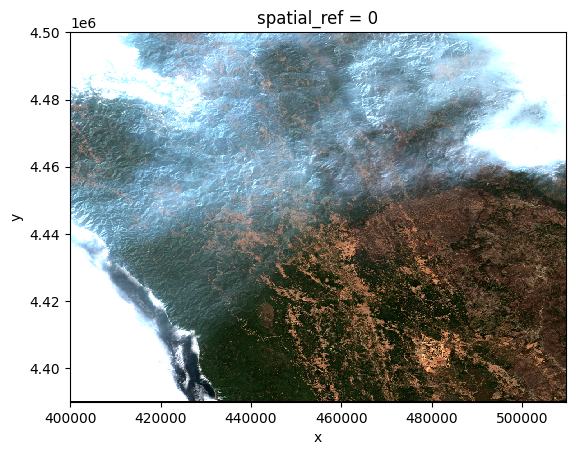

In [26]:
list(dp_rioxarray)[0].sel(band=[4,5,6]).astype("int").plot.imshow(rgb="band")

In [27]:
print(dp_rioxarray)
dp_xbatcher = dp_rioxarray.slice_with_xbatcher(input_dims={"y": 512, "x": 512})
print(dp_xbatcher)
print(f"Number of chips: {len(dp_xbatcher)}")

RioXarrayReaderIterDataPipe
XbatcherSlicerIterDataPipe
Number of chips: 4


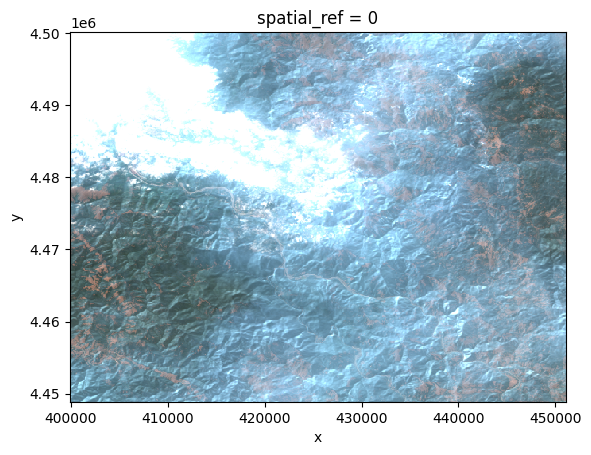

In [28]:
list(dp_xbatcher)[0].sel(band=[4,5,6]).astype("int").plot.imshow(rgb="band")

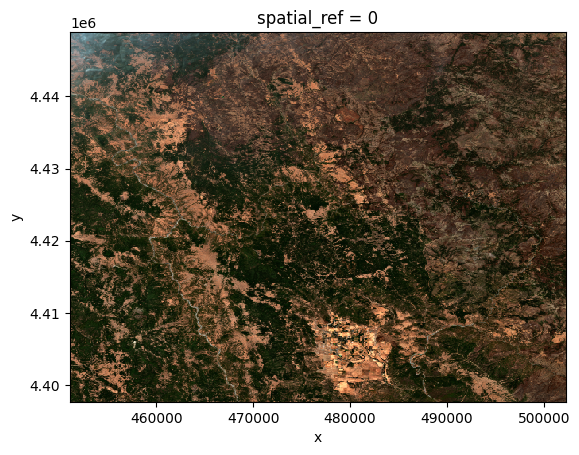

In [29]:
list(dp_xbatcher)[3].sel(band=[4,5,6]).astype("int").plot.imshow(rgb="band")

In [30]:
chips = [chip for chip in dp_xbatcher]
print(f"Number of chips: {len(chips)}")

Number of chips: 4


In [31]:
sample = chips[0]
sample.shape

(6, 512, 512)

In [32]:
dp_batch = dp_xbatcher.batch(batch_size=2)
print(f"Number of items in first batch: {len(list(dp_batch)[0])}")

Number of items in first batch: 2


In [33]:
list(dp_batch)[0]

[<xarray.DataArray (band: 6, y: 512, x: 512)>
 array([[[   0,    0,    0, ...,    0,    0,    0],
         [   0, 6172, 6289, ..., 1907, 1919, 1895],
         [   0, 5987, 6355, ..., 1918, 1889, 1938],
         ...,
         [   0, 1664, 1703, ..., 1347, 1461, 1437],
         [   0, 1803, 1849, ..., 1397, 1447, 1409],
         [   0, 1542, 1520, ..., 1585, 1759, 1977]],
 
        [[   0,    0,    0, ...,    0,    0,    0],
         [   0, 5755, 5851, ..., 1651, 1643, 1619],
         [   0, 5524, 5904, ..., 1650, 1623, 1660],
         ...,
         [   0, 1451, 1474, ..., 1351, 1474, 1434],
         [   0, 1557, 1582, ..., 1380, 1431, 1367],
         [   0, 1347, 1318, ..., 1536, 1689, 1885]],
 
        [[   0,    0,    0, ...,    0,    0,    0],
         [   0, 5473, 5564, ..., 1291, 1281, 1229],
         [   0, 5184, 5605, ..., 1324, 1269, 1293],
         ...,
 ...
         ...,
         [   0,  106,  104, ...,  135,  161,  156],
         [   0,  113,  112, ...,  127,  144,  128],
   

Stack many chips in mini-batches into a single tensor 🥞
Let’s now stack all these chips into a single tensor per batch, with a (number, channel, height, width) shape like (10, 1, 512, 512). We’ll need a custom 🪄 collate function to do the conversion (from xarray.Dataset to torch.Tensor) and stacking.

In [34]:
import torch
def xr_collate_fn(samples) -> torch.Tensor:
    """
    Converts individual xarray.DataArray objects to a torch.Tensor (int16
    dtype), and stacks them all into a single torch.Tensor.
    """
    tensors = [
        torch.as_tensor(data=sample.data.astype(dtype="int16")) for sample in samples
    ]
    return torch.stack(tensors=tensors)

In [35]:
dp_collate = dp_batch.collate(collate_fn=xr_collate_fn)
print(f"Number of mini-batches: {len(list(dp_collate))}")
print(f"Mini-batch tensor shape: {list(dp_collate)[0].shape}")

Number of mini-batches: 2
Mini-batch tensor shape: torch.Size([2, 6, 512, 512])


In [36]:
dataloader = torch.utils.data.DataLoader(dataset=dp_collate, batch_size=None)
for i, batch in enumerate(dataloader):
    tensor = batch
    print(f"Batch {i}: {tensor.shape}")

Batch 0: torch.Size([2, 6, 512, 512])
Batch 1: torch.Size([2, 6, 512, 512])
